<h1> <center> Compressive Sensing </center> </h1>

## Introduction
The principal problem of compressive sensing is to recover the sparse vector $x$ of size $N$ from linear observation $y$:

$$y = A \cdot x$$

when the number $m$ of observation is much lower than the number of unknows $N$.
Usually this type of problems are ill posed since $m << N$, but since the space of x is sparse, this problem has solution!

### Some Intuition

for example a 2 dimentional sparse space in a 3 dimentional word is


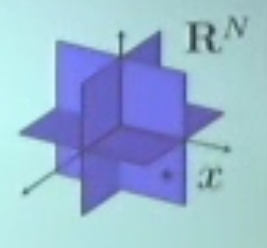

In [10]:
from IPython.display import Image
Image('spaziosparso.png',width=500)

So if we define a plane in this space we have that this plane will intersect 
the axis in some points... and the result for our problem are the one that minimize our objective function.

$$\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & ||x||_0 \\
& \text{subject to}
& & y = A \cdot x
\end{aligned}
\end{equation*}$$

But since this problem is non-convex and NP-hard. We relaxe the problem with other kind of spaces...


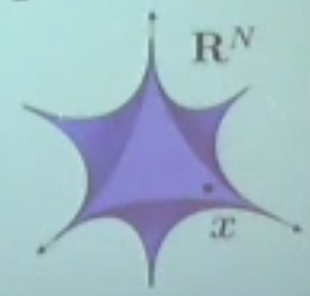

In [11]:
Image('normaP.png',width=500)

this picture show as a norm $p$ space when $p\leq 1$. But this spaces are still Non-Convex!!!
So under some condition we can relax to a norm 1 problem that has different recovery algorithms:



1) *Basis Pursuit*
$$\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & ||x||_1 \\
& \text{subject to}
& & y = A \cdot x
\end{aligned}
\end{equation*}$$

2) *Lasso*
$$\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & || A \cdot x - y||_2 \\
& \text{subject to}
& & ||x||_1 \leq \tau
\end{aligned}
\end{equation*}$$

3)*Orthogonal matching pursuit*
  * Initialization: $S^0 = \emptyset, \quad x^0 = 0$
  * Repeat until a stop criterion is met:
      *  $S^{n+1} = S^n \cup \{ j_{n+1}\}, \quad j_{n+1}= argmax\{|A^H(y- A\cdot x^n)|\}$
      * $x^{n+1} =  argmin_z\{|y - A \cdot z|_2 , supp(z) \subset S^{n+1}\}$
  * Output $x^* = x^{n+1}$


### **Conditions for unique recovery of sparse vectors**

Thanks to the results found by *Emmanuel Candès, Justin Romberg, Terence Tao and David Donoho*
we have the following theorems that says:

$$$$
### Th 1

**Given $A \in C^{m \times N}$, the following properties are equivalent**
  
1) *If $A\cdot x = A \cdot z$ and both $x$ and $z$ are s-sparse, then $x=z$*

2) *The null-space of $A$ does not contain and $2s$-sparse vector other than the $0$ vector*
   
3) *Every set of $2s$ columns of $A$ is linearly independent* 


$$$$
### Th 2

**Given $A \in C^{m \times N}$, with $l_2-$normalized columns, if ** 
$$\mu_1(s) + \mu_1(s+1) < 1$$

*Then every $s-$sparse vector $x$ is exactly recovered from the measurement vector $y = A \cdot x$ via basis pursuit or after at most s iterations of Orthogonal Matching Pursuit*

NOTE: the result hold if $\mu < \frac{1}{2s - 1}$


where:
$$\mu = \underset{1\leq i \neq j \leq N}{\text{max}} |\langle a_i , a_j \rangle| $$

$$\mu_1(s) = \underset{i \in [N]}{\text{max}}\; \text{max}\Bigg\{ \sum_{j \in S}  |\langle a_i , a_j \rangle|  \quad , S \subset [N], \; \text{card}(S)= s, \; i \notin S  \Bigg\}$$

![](spaziosparso.png)

In [0]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, show, figure, title

import numpy as np

import scipy 
from scipy.io import wavfile
from scipy import signal

from scipy.fftpack import dst, idst

import IPython.display as ipd

import cvxpy as cvx

from sklearn.linear_model import Lasso
from time import time


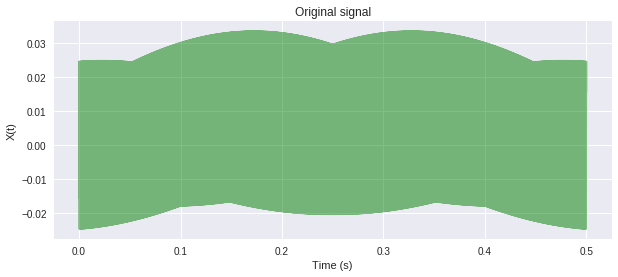

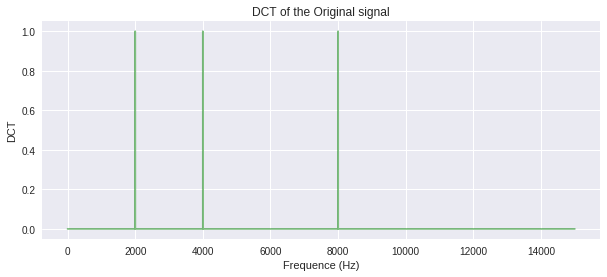

In [2]:
###########   Let's create a signal
Frequenze_udibili = 30e3
durata_suono = 1./2 # durata in secondi del suono
campioni = int(Frequenze_udibili*durata_suono)

X_f = np.zeros(campioni)

## frequenze per il segnale
f1 = 2000
f2 = 4000
f3 = 8000

X_f[[f1,f2,f3]] =  1

# signal cration
t = np.linspace(0,durata_suono,int(campioni))
X = idst(X_f, type=2, norm='ortho')

figure(figsize=[10,4])
plot(t,X, 'g', alpha=0.5)
title('Original signal')
plt.xlabel('Time (s)')
plt.ylabel('X(t)')

## Discrete transform
figure(figsize=[10,4])
plot(dst(X, type=2, norm='ortho', n = campioni),'g', alpha = 0.5)
title('DCT of the Original signal')
plt.xlabel('Frequence (Hz)')
plt.ylabel('DCT')


## listen
ipd.Audio(X, rate=Frequenze_udibili)

Following the **Shannon-Nyquist** Theorem we should sample each $\frac{1}{2B}= \frac{1}{2\cdot 8000}= 0,0000625 \; s$!  That means that in a second we need $\frac{1 \; s}{0,0000625 \; s} = 16000$ sampled values

But exploiting the Compressive Sensing theory, and looking for a random matrix A that has low coherence, we can...

Sampling time for Compressive sampling 0.001000000
Compression respect the Shannon-yquist 0.062500000


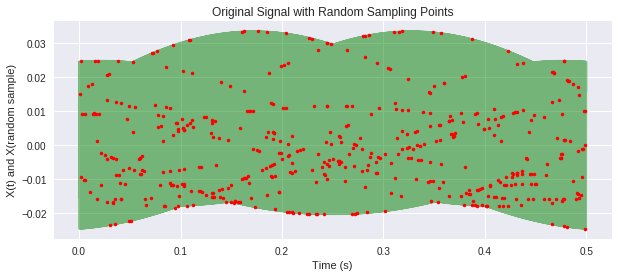

In [3]:
### lower frequence sampling
sampled_compr = 500
yi = np.random.randint(0,campioni,sampled_compr)
yi = np.sort(yi)

Y = X[yi]

figure(figsize=[10,4])
plot( t, X, 'g', alpha=0.5)
plot(t[yi], Y, 'r.', alpha=1.)
title('Original Signal with Random Sampling Points')
plt.xlabel('Time (s)')
plt.ylabel('X(t) and X(random sample)')

print("Sampling time for Compressive sampling {:1.9f}".format(1./(sampled_compr*2)))
print("Compression respect the Shannon-yquist {:1.9f}".format((sampled_compr*2)/16000.))

D = dst(np.eye(campioni), type=2, norm= 'ortho')  # Construct the DCT basis functions for each of the frequencies
A = D[yi,: ]                  # Downsample based on our random sampling


In this simple example we create a particular random matrix, that exploit the fact that the sine basis of the DST are orthonormal and thus if we take enough samples the coherence of the matrix will be small,  builted such a way that:

$$A  =  \text{diag}(\delta) \cdot D $$

where the vector $\delta$ is builted from a sample of Bernoulli Variables, while $D$ is the DST basis.


## Basis Pursuit for reconstruction

In [6]:
start = time()
m = A.shape[1]
x = cvx.Variable(m)

objective = cvx.Minimize( cvx.norm(x, p=1))
constraint = [Y == A*x]

prob = cvx.Problem(objective, constraint)
prob.solve()

print("time execution: %.3f"%(time()- start))

time execution: 47.663


Solution is %99.980 sparse


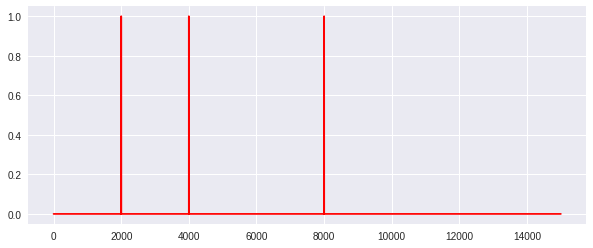

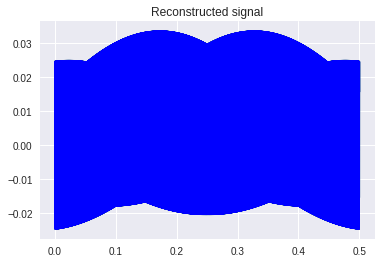

In [7]:
figure(figsize=[10,4])
freq_pred_BP = x.value
plot(freq_pred_BP, 'r',alpha = 1.)

sparseness = (np.sum(np.abs(x.value) <= 0.1)+ 0.)/campioni
print("Solution is %{:0.3f} sparse".format(100.*sparseness))

Xhat_BP = idst(freq_pred_BP, type=2, norm='ortho')
figure()
plot(t, X,'g-',t, Xhat_BP, 'b-')
title('Reconstructed signal')


## listen
ipd.Audio(Xhat_BP, rate=Frequenze_udibili)


## LASSO for reconstruction

time execution: 0.254
Solution is %99.980 sparse


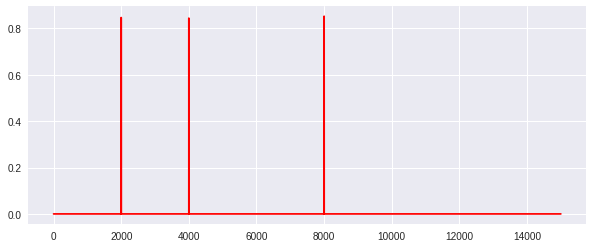

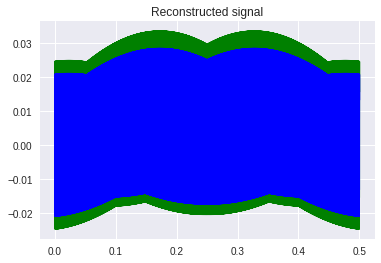

In [10]:
start = time()
lasso = Lasso(alpha=0.00001)
lasso.fit(A,Y)
print("time execution: %.3f"%(time()- start))

figure(figsize=[10,4])
freq_pred_LASSO = lasso.coef_
plot(freq_pred_LASSO, 'r',alpha = 1.)

sparseness = (np.sum(lasso.coef_ == 0)+ 0.)/campioni
print("Solution is %{:0.3f} sparse".format(100.*sparseness))

Xhat_LASSO = idst(freq_pred_LASSO, type=2, norm='ortho')
figure()
plot(t, X,'g-',t, Xhat_LASSO, 'b-')
title('Reconstructed signal')


## listen
ipd.Audio(Xhat_LASSO, rate=Frequenze_udibili)


## Orthogonal Matching Pursuit for reconstruction

In [0]:
def matching_pursuit(A, signal, iterations = 30):
    residual = np.copy(signal)
    Dictionary = np.copy(A)
    it = 1
    coeffs = []
    indici = [i for i in range(Dictionary.shape[1])]
    for i in range(iterations):
        col_new = np.argmax(np.abs(np.dot(residual, Dictionary)))
        coeffs.append(indici.pop(col_new))
        Dictionary = np.delete(Dictionary , col_new, axis=1)
        X = np.copy(A[:, coeffs])
        a_n = np.dot(np.dot(   np.linalg.inv( np.dot(  X.T, X ) ), X.T), signal)    # beta = (X.t * X)^-1 X.t y      
        residual -=  np.dot(A[:, coeffs], a_n)
        it += 1
    return np.array(coeffs), a_n
  

time execution: 0.773
Solution is %99.800 sparse


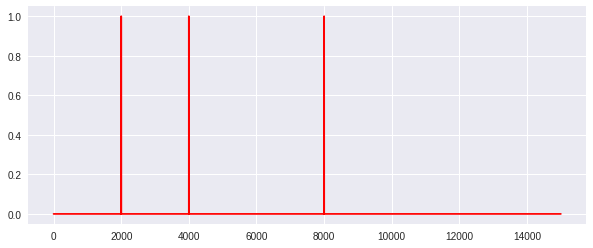

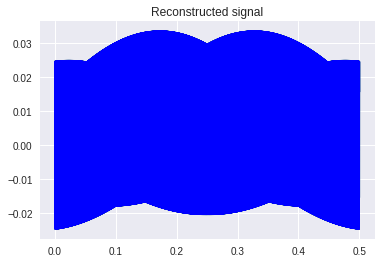

In [16]:
start = time()
coefs_MP, values = matching_pursuit(A, Y)
print("time execution: %.3f"%(time()- start))


freq_pred_MP = np.zeros(15000)
freq_pred_MP[coefs_MP.astype(np.int)] = values

sparseness = (np.sum( freq_pred_MP == 0)+ 0.)/campioni
print("Solution is %{:0.3f} sparse".format(100.*sparseness))

figure(figsize=[10,4])
plot(freq_pred_MP, 'r',alpha = 1.)

Xhat_MP = idst(freq_pred_MP, type=2, norm='ortho')
figure()
plot(t, X,'g-',t, Xhat_MP, 'b-')
title('Reconstructed signal')




## listen
ipd.Audio(Xhat_MP, rate=Frequenze_udibili)



#Dictionary Learning

But in real cases we have the problem that is hard to find a low coherence matrix that has a sparse rappresentation of the signal, so we need to build a new and specific one using Dictionary Learning methods.


#### Real data explanation

I have 300 sound files with some words and some noise, and my goal is to find a good Dictionary for this data

In [2]:
i,h = 0,1    ##### noise  18,3

train_audio_path = './my_data'
words = os.listdir("./my_data/")
file = os.listdir("./my_data/"+ words[i])[h]
filename = '/'+words[i] + '/'+ file
print(words[i], file)
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

print(len(samples))
ipd.Audio(samples, rate=sample_rate)

('seven', 'b9f46737_nohash_0.wav')
16000


Text(0.5,0,u'Seconds')

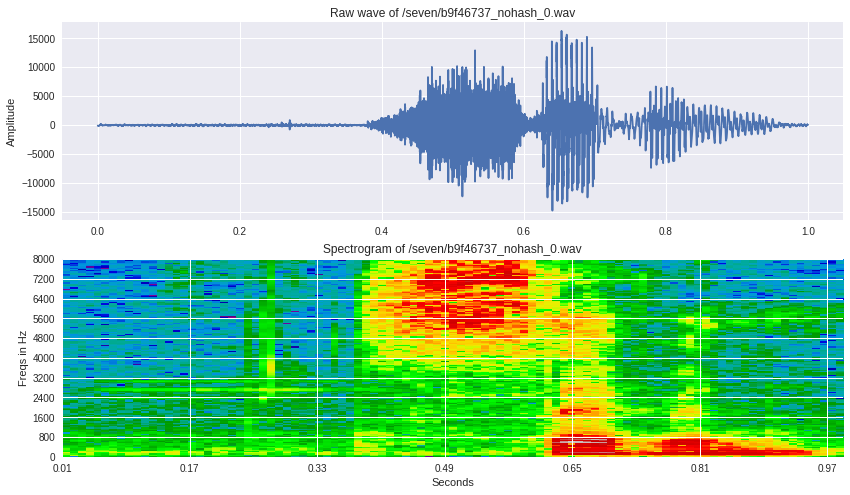

In [3]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)
  
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, len(samples) / (sample_rate+1e-10), len(samples)), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()], cmap = "nipy_spectral")
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

## Prepare the data for DL

In [0]:
words = [w for w in os.listdir("./my_data/") if w not in ['datalab','.ipython','my_data.zip','.cache',]]

def my_split(arr, win):
  splitted = []
  inter = (len(arr)//win)
  resto = len(arr) % win
  for i in range(inter):
    splitted.append(arr[i*win : (i*win + win) ])
  if resto>0:
    last = np.pad(arr[inter*win:], pad_width=(0, win-resto), mode="constant"   )
    splitted.append(last)
  return splitted

In [6]:
from scipy.io import wavfile

# creo il dataset su cui fittare il dictionary learning
data = []
win = 100
it = 0
files = {}
for w in words:
  nu = 0
  for file in os.listdir("./my_data/"+ w):
    filename = '/'+ w + '/'+ file
    if w == "_background_noise_":
      if file == 'README.md':
        continue
    try:
      sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
      if len(samples)>15890:
        samples = samples[:15890]

      files[it] = (file,len(samples), w , nu)
      data.extend(my_split(samples, win))
      it +=1
      nu +=1

    except:
      pass
      print(w, file)


print("total numbers of signals: {} ### number of different voices: {} ".format(len(data), it))
data = np.concatenate(data).reshape((-1,win))
data.shape

total numbers of signals: 47642 ### number of different voices: 306 


(47642, 100)

## Dumb iterative algorithm

The goal is:

$$\begin{equation*}
\begin{aligned}
& \underset{x, D}{\text{minimize}}
& & \sum_i || y(i) -D \cdot x(i) ||_2 + \lambda ||x(i)||_1 \\
& \text{subject to}
& & ||D(j)||_2 = 1, \quad \forall j \in cols[D]
\end{aligned}
\end{equation*}$$


and my first approach is to minimize alternatively $D$ and $x$ up to convegence...

In [0]:
class DictionaryLearning:
  def __init__(self, dimensione_dizionario, lamb, iterazioni):
    self.dimensione_dizionario = dimensione_dizionario
    self.lamb = lamb
    self.iterazioni = iterazioni
    
  def fit(self, data):
    self.win = data.shape[1]
    self.batch = data.shape[0]
    self.y = np.copy(data).T
    self.D = np.random.randn(self.win, self.dimensione_dizionario)
    for i in range(self.iterazioni):
      self.x = self.update_sparse_encoding(self.D)
      self.D = self.update_dictionary(self.x)
    self.x = self.update_sparse_encoding(self.D)
    return self.D
    
  def update_dictionary(self, x ):
    D = cvx.Variable(shape= (self.win, self.dimensione_dizionario))
    obj = cvx.Minimize(cvx.sum_squares(self.y - D*x))
    prob = cvx.Problem(objective=obj )
    print(prob.solve())
    return D.value
  
  def update_sparse_encoding(self, D):
    x = cvx.Variable(shape=(self.dimensione_dizionario , self.batch))
    obj = cvx.Minimize(cvx.sum_squares(self.y - D*x)    +   self.lamb *cvx.atoms.norm(x, p=1))
    prob = cvx.Problem(objective=obj )
    print(prob.solve())
    return x.value
  

In [8]:
print('Learning the dictionary...')
t0 = time()
d = DictionaryLearning(dimensione_dizionario=90, lamb=100, iterazioni=1)
real_sign = data[159:159*2]
d.fit(real_sign)
y_hat = np.dot(d.D, d.x)
dt = time() - t0
print('done in %.2fs.' % dt)

Learning the dictionary...
7670395237.154451
1806809.0283940642
26117504.321402665
done in 79.53s.


file:  5a9f7324_nohash_2.wav 
lunghezza campioni: 15890 
parola:  seven 
registrazione numero: 0 
Solution is %27.778 sparse


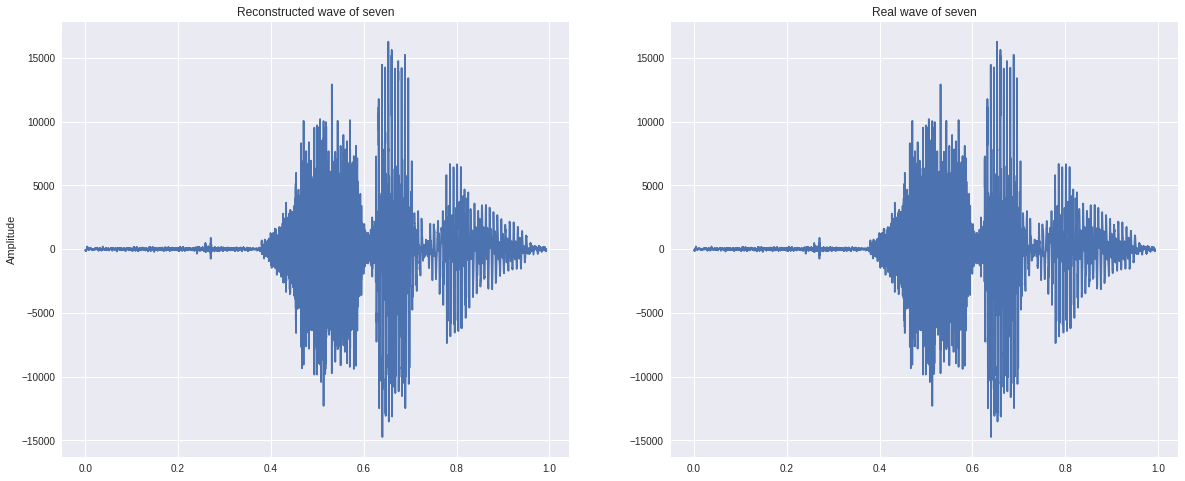

In [9]:
el = 0
sign_reco = y_hat.T.flatten()
real_sign = real_sign.flatten()
print("file:  %s \nlunghezza campioni: %i \nparola:  %s \nregistrazione numero: %i " % files[el])


sparseness = (np.sum(np.abs(d.x) <= 0.1)+ 0.)/d.dimensione_dizionario
print("Solution is %{:0.3f} sparse".format(100.*sparseness))


fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(121)
ax1.set_title('Reconstructed wave of ' + files[el][2])
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, len(sign_reco) / (sample_rate+1e-10), len(sign_reco)), sign_reco)

ax2 = fig.add_subplot(122)
ax2.set_title('Real wave of ' + files[el][2])
ax2.plot(np.linspace(0, len(real_sign) / (sample_rate+1e-10), len(sign_reco)), real_sign)



ipd.Audio(sign_reco, rate=sample_rate)

## Online Dictionary Learning 

When the size of the training size is too big or when the input data come in form of a stream, in such cases we are in the field of study of online learning which essentially suggests iteratively updating the model upon the new data points x becoming available.

1) Draw a new sample $y_t$  for t = 1,... , T   

2) Find a sparse coding using ("Lasso", "Basis Pursuit" or "OMP")       $\quad r_t = \underset{r \in \mathbb{R}^n}{\text{argmin}}\bigg(\frac{1}{2}  ||  y_t  - D\cdot x_t||_2 + \lambda ||x_t||_1\bigg)$

3) Update dictionary using **block-cordinate** approach:    $\quad D_t = \underset{D \in \mathbb{C}}{\text{argmin}} \frac{1}{t} \sum_{i=1}^t  \big( \frac{1}{2}  ||  y_t  - D\cdot x_t||_2  \big) $



This method allows us to gradually update the dictionary as new data becomes available for sparse representation learning and helps drastically reduce the amount of memory needed to store the dataset (which often has a huge size).



Learning the dictionary...
done in 90.04s.


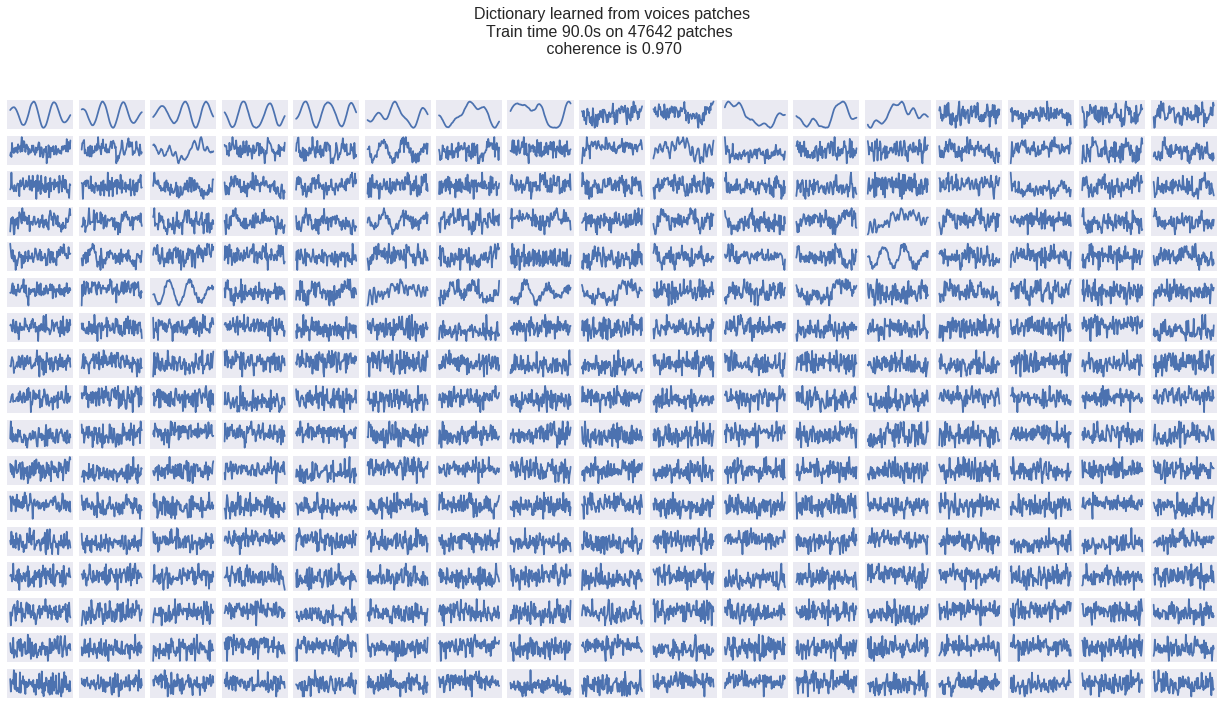

In [106]:
from time import time
from sklearn.decomposition import MiniBatchDictionaryLearning

print('Learning the dictionary...')
t0 = time()
dico = MiniBatchDictionaryLearning(n_components=300, alpha=0.1, n_iter=500)
V = dico.fit(data).components_
dt = time() - t0
print('done in %.2fs.' % dt)

def coherence(A):
  return np.max(np.abs(np.dot(A.T, A) - np.diag(np.dot(A.T, A).diagonal())))

plt.figure(figsize=(20, 10))
total_basis = len(V)
col = int(np.sqrt(total_basis))
for i, comp in enumerate(V[:col*col]):
    plt.subplot(col, col, i + 1)
    plt.plot(np.linspace(0, 1, len(comp)), comp)
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary learned from voices patches\n' +
             'Train time %.1fs on %d patches \n coherence is %.3f' % (dt, len(data), coherence(V)),
             fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

      

In [133]:
print("rebuilding the signals .... ")
t0 = time()
dico.set_params(transform_algorithm='omp', **{'transform_n_nonzero_coefs': 60})
code = dico.transform(data)
patches = np.dot(code, V)
dt = time() - t0
print('done in %.2fs.' % dt)

def rebuild_all_from_dic(matrix, win):
  global files
  attuale = 0
  ritorno = []
  for k in range(len(files)):
    lunghezza_file = files[k][1]
    num = files[k][1]//win
    resto = int(bool(files[k][1] % win))
    ritorno.append(   matrix[attuale: (num + resto + attuale)].flatten()    )
    attuale += num + resto
    
  return ritorno

all_rec = rebuild_all_from_dic(patches, win)
real_data = rebuild_all_from_dic(data, win)



rebuilding the signals .... 
done in 302.87s.


file:  483e2a6f_nohash_1.wav 
lunghezza campioni: 15890 
parola:  tree 
registrazione numero: 5 


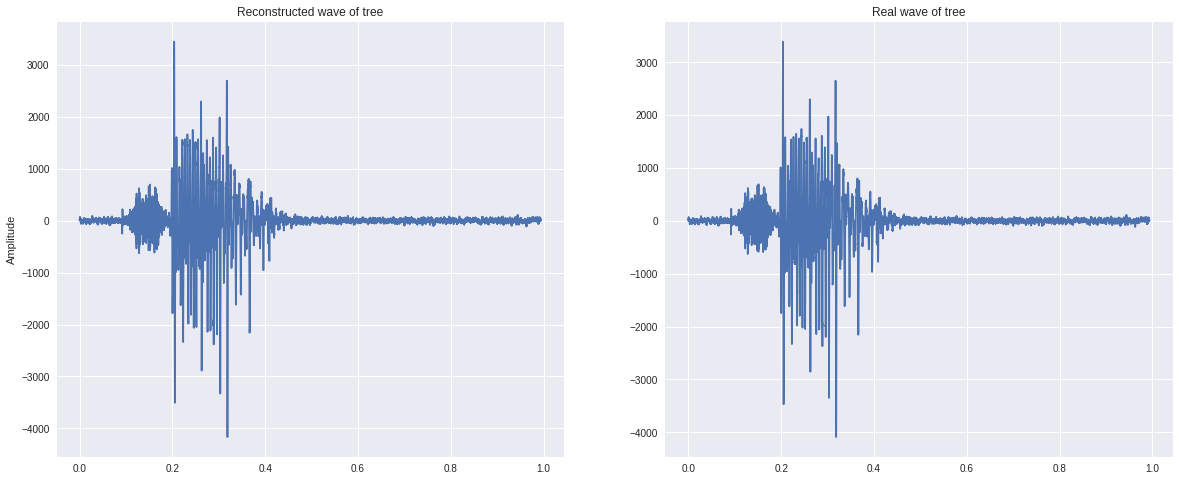

In [134]:
el = 35        #####  noise 192
sign_reco = all_rec[el]
real_sign = real_data[el]
print("file:  %s \nlunghezza campioni: %i \nparola:  %s \nregistrazione numero: %i " % files[el])

fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(121)
ax1.set_title('Reconstructed wave of ' + files[el][2])
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, len(sign_reco) / (sample_rate+1e-10), len(sign_reco)), sign_reco)

ax2 = fig.add_subplot(122)
ax2.set_title('Real wave of ' + files[el][2])
ax2.plot(np.linspace(0, len(real_sign) / (sample_rate+1e-10), len(sign_reco)), real_sign)



ipd.Audio(sign_reco, rate=sample_rate)

In [10]:
ipd.Audio(real_sign, rate=sample_rate)

#### Loading data

In [4]:
!ls

datalab  my_data  my_data.zip


In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving my_data.zip to my_data.zip
User uploaded file "my_data.zip" with length 17838507 bytes


In [0]:
!mkdir my_data
!unzip my_data.zip -d my_data

#### Installing Library


In [7]:
!pip install cvxpy

 | / - \ | / - done
  Stored in directory: /content/.cache/pip/wheels/6d/78/df/bd8d02476516cf184699705248d001a806c220add5e3994caa
  Running setup.py bdist_wheel for ecos ... - \ | / - \ | / - \ | / - \ | / - \ | / - done
  Stored in directory: /content/.cache/pip/wheels/50/91/1b/568de3c087b3399b03d130e71b1fd048ec072c45f72b6b6e9a
  Running setup.py bdist_wheel for scs ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done
  Stored in directory: /content/.cache/pip/wheels/ff/f0/aa/530ccd478d7d9900b4e9ef5bc5a39e895ce110bed3d3ac653e
  Running setup.py bdist_wheel for multiprocess ... - \ | / - done
  Stored in directory: /content/.cache/pip/wheels/8b/36/e5/96614ab62baf927e9bc06889ea794a8e87552b84bb6bf65e3e
  Running setup.py bdist_wheel for fastcache ... - \ done
  Stored in directory: /content/.cache/pip/wheels/b7/90/c0/da92a